# Previous actions

Import libraries

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import plotly.graph_objects as go
import pandas as pd

Mount Drive

In [ ]:
#Mounting Google Drive files
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

# Architectures definition

UNet

In [ ]:
#Definición de los bloques de la arquitectura UNET
import torch.nn.functional as F
import torch

def conv3x3_bn(ci,co):
  return torch.nn.Sequential(
      torch.nn.Conv2d(ci,co,3,padding=1),
      torch.nn.BatchNorm2d(co),
      torch.nn.ReLU(inplace=True)
  )

def encoder_conv(ci,co):
  return torch.nn.Sequential(
      torch.nn.MaxPool2d(2),
      conv3x3_bn(ci,co),
      conv3x3_bn(co,co)
  )

class deconv(torch.nn.Module):
  def __init__(self,ci,co):
    super(deconv,self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(ci,co,2,stride=2)
    self.conv1 = conv3x3_bn(ci,co)
    self.conv2 = conv3x3_bn(co,co)

  def forward(self,x1,x2):
    x1 = self.upsample(x1)
    diffX = x2.size()[2] - x1.size()[2]
    diffY = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, (diffX, 0, diffY, 0))
    x= torch.cat([x2,x1],dim=1)
    x= self.conv1(x)
    x= self.conv2(x)
    return x

class UNet(torch.nn.Module):
  def __init__(self,n_classes=2,in_ch=1):
    super().__init__()

    c = [32,64,128]

    self.conv1 = torch.nn.Sequential(
        conv3x3_bn(in_ch,c[0]),
        conv3x3_bn(c[0],c[0])
    )

    #capas del encoder
    self.conv2 = encoder_conv(c[0],c[1])
    self.conv3 = encoder_conv(c[1],c[2])

    #capas del decoder
    self.deconv1 = deconv(c[2],c[1])
    self.deconv2 = deconv(c[1],c[0])

    self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding = 1)

  def forward(self,x):
    #encoder
    x1 = self.conv1(x)
    x2 = self.conv2(x1)
    x3 = self.conv3(x2)
    #decoder
    x = self.deconv1(x3,x2)
    x = self.deconv2(x,x1)
    x = self.out(x)
    return x

Resnet 50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

resnet_50 = fcn_resnet50(pretrained=False, num_classes = 2, aux_loss = False ) 
resnet_50.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Resnet 101

In [ ]:
from torchvision.models.segmentation import fcn_resnet101
resnet_101 = fcn_resnet101(pretrained=False, progress=True, num_classes=2, aux_loss=None)
resnet_101.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Deeplab v3 resnet 50

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50
deeplabv3_resnet50_train =deeplabv3_resnet50(pretrained=False, progress=True, num_classes=2, aux_loss=None)
deeplabv3_resnet50_train.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Deeplab v3 resnet 101

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101
deeplabv3_resnet101_train =deeplabv3_resnet101(pretrained=False, progress=True, num_classes=2, aux_loss=None)
deeplabv3_resnet101_train.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#Upload a model

In [ ]:
pretrained_list = []
pretrained_list = [i for i in os.listdir('/content/drive/MyDrive/TFG/Modelos/Models Bilayer/Pretrained')]
params = {'model':'', 'model_name':''}

In [ ]:
#@title Do you want to upload a model?
Yes = True #@param {type:"boolean"}
if Yes:
  for i in pretrained_list: 
    print('\n' + i)
  #@markdown Select the architecture (must coincide with the one in Insert)
  Architecture = "UNet" #@param ["UNet", "resnet_50", "resnet_101", "deeplabv3_resnet50", "deeplabv3_resnet101"]
  #@markdown Available models are shown below if 'Yes' is selected. Copy and insert the name in the 'Insert' tag
  Insert = 'UNet_lr_0.1_Augmentation_True_Batch_12_Epochs_50_Early_10_TDLength_800.pt' #@param {type:"string"}
  params['model_name'] = Architecture

  if params['model_name']=='UNet':
    U = UNet()
    params['model'] = U
  if params['model_name']=='resnet_50':
    params['model']  = resnet_50
  elif params['model_name']=='resnet_101':
    params['model']  = resnet_101
  elif params['model_name']=='deeplabv3_resnet50':
    params['model']  = deeplabv3_resnet50_train
  elif params['model_name']=='deeplabv3_resnet101':
    params['model']  = deeplabv3_resnet101_train


UNet_lr_0.1_Augmentation_True_Batch_12_Epochs_50_Early_10_TDLength_800.pt

UNet_lr_0.1_Augmentation_False_Batch_12_Epochs_50_Early_10_TDLength_800 .pt

resnet_50_lr_0.1_Augmentation_False_Batch_12_Epochs_50_Early_10_TDLength_800 .pt

resnet_50_lr_0.1_Augmentation_True_Batch_12_Epochs_50_Early_10_TDLength_800 .pt

resnet_101_lr_0.1_Augmentation_True_Batch_6_Epochs_50_Early_10_TDLength_800 .pt

resnet_101_lr_0.1_Augmentation_False_Batch_6_Epochs_50_Early_10_TDLength_800.pt

deeplabv3_resnet50_lr_0.1.pt


In [ ]:
#This will be the path to file
pretrained_model_path = '/content/drive/MyDrive/TFG/Modelos/Models Bilayer/Pretrained/' + Insert

# OCTs Selection

In [ ]:
VolFiles = os.listdir('/content/drive/MyDrive/TFG/VOL IMAGES')
for i in VolFiles: 
  print(i)
#@markdown Available OCT Scan Folders are shown below. Copy and insert the name in the 'Insert' tag and then click 'Run' button
Insert = 'JPG07092021173103' #@param {type:"string"}
OCTPath = '/content/drive/MyDrive/TFG/VOL IMAGES/'+Insert

JPG07092021173103
JPG12092021113303


#OCTs predictions

In [ ]:
#First we sort folder files by name to avoid a wrong later representation
SortedList = os.listdir(OCTPath)
def last_2chars(x):
    return(x[:2])

OCTList = sorted(SortedList, key = last_2chars)

In [ ]:
OCT = []
Shapes = []
pred_mask_list = []
counter = 0
for i in OCTList[:-1]:
  OCT.append(OCTPath + '/' + i)
  OCTImg = plt.imread(OCTPath + '/' + i)
  OCTImg = np.array(OCTImg)
  Shapes.append(OCTImg.shape)
  OCTImg = OCTImg/255
  OCTImg = cv2.resize(OCTImg, (512,512))
  OCTImg = OCTImg.astype('float32')
  model = params['model'].to('cpu')
  model.eval()
  pretrained = torch.load(pretrained_model_path,map_location=torch.device('cpu'))
  model.load_state_dict(pretrained) 
  with torch.no_grad():
    if params['model_name']=='UNet':
      output = model(torch.tensor(OCTImg).unsqueeze(0).unsqueeze(0))
    else: 
      output = model(torch.tensor(OCTImg).unsqueeze(0).unsqueeze(0))['out']
    pred_mask = torch.argmax(output.squeeze(0), axis=0)
    pred_mask = cv2.resize(np.array(pred_mask.cpu()).astype('float32'),(Shapes[counter][1],Shapes[counter][0]))
    pred_mask = pred_mask.astype('int32')
    pred_mask_list.append(pred_mask) 
  counter+=1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



# Thickness calculation

In [ ]:
Espesor = []
ComienzoEspesor=[]
FinEspesor=[]
inicio=[]
final=[]
for k in pred_mask_list:
  EspesorImagen = []
  ComienzoEspesor=[]
  FinEspesor=[]
  for i in range(k.shape[1]):
    StartFin,EndFin = 0,0
    start,end = 0,0
    for j in range(k.shape[0]):
      try:
        if k[j,i]==1 and k[j-1,i]!=1:
          start = j
        if k[j,i]==0 and k[j-1,i]!=0:
          end = j
          if (end-start) > k.shape[0]*0.1:
            if StartFin==0: 
              StartFin = start
            EndFin = end
      except:
        continue
    EspesorImagen.append(EndFin - StartFin)
    ComienzoEspesor.append((StartFin))
    FinEspesor.append((EndFin))
  Espesor.append(np.array(EspesorImagen))
  inicio.append(np.array(ComienzoEspesor))
  final.append(np.array(FinEspesor))
inicio=np.array(inicio)
final=np.array(final)
Espesor =np.array(Espesor)

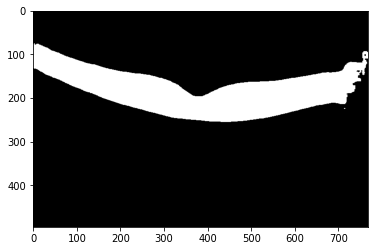

In [ ]:
plt.imshow(pred_mask_list[15],cmap='gray')

Reducing width to avoid irregularity

In [ ]:
EspesorAcotado = []
InicioAcotado = []
FinAcotado = []
for i in range(len(Espesor)):
  EspesorAcotado.append(Espesor[i][30:-100])
  InicioAcotado.append(inicio[i][30:-100])
  FinAcotado.append(final[i][30:-100])
EspesorAcotado = np.array(EspesorAcotado)
InicioAcotado = np.array(InicioAcotado)
FinAcotado = np.array(FinAcotado)

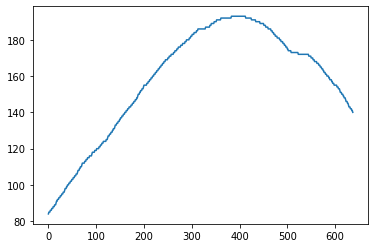

In [ ]:
plt.plot(InicioAcotado[3])

# Data interpolation

(638, 768)


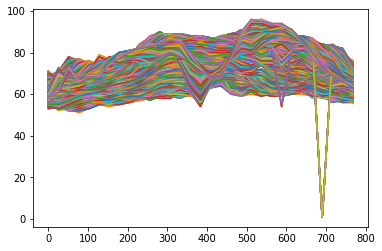

In [ ]:
from scipy.interpolate import interp1d
Interpol = []
interpoli=[]
interpolf=[]
Interpol2D = []
InterpolI2D = []
InterpolF2D = []

value_items = {'SizeX': 768,'ScaleZ':0.004}
for i in range(len(EspesorAcotado[0])):
    x = np.linspace(1,len(Espesor),len(Espesor))
    xnew = np.linspace(1,len(Espesor),value_items['SizeX'])
    f = interp1d(x,EspesorAcotado[:,i])
    fi =interp1d(x,InicioAcotado[:,i])
    ff=interp1d(x,FinAcotado[:,i])
    Interpol.append(f(xnew))
    interpoli.append(fi(xnew))
    interpolf.append(ff(xnew))
    plt.plot(Interpol[i])
Interpol = np.array(Interpol)
interpoli = np.array(interpoli)
interpolf = np.array(interpolf)
print(Interpol.shape)
for i in range(len(EspesorAcotado[0])):
  x=np.linspace(1,len(EspesorAcotado[0]),value_items['SizeX'])
  xnew = np.linspace(1,len(EspesorAcotado[0]),value_items['SizeX']*2)
  f = interp1d(x,Interpol[i,:])
  fi = interp1d(x,interpoli[i,:])
  ff = interp1d(x,interpolf[i,:])
  Interpol2D.append(f(xnew))
  InterpolI2D.append(fi(xnew))
  InterpolF2D.append(ff(xnew))

Interpol2D = np.array(Interpol2D)
InterpolI2D = np.array(InterpolI2D)
InterpolF2D = np.array(InterpolF2D)

x = np.linspace(1,value_items['SizeX'],value_items['SizeX'])
y = np.linspace(1,value_items['SizeX'],value_items['SizeX'])
ys,xs = np.meshgrid(y,x)

In [ ]:
Interpol2D.shape, xs.shape

((638, 1536), (768, 768))

# 3D Graphs

First and last layer

In [ ]:
# Read data from a csv
Start = interpoli*value_items['ScaleZ']*-1
End = interpolf*value_items['ScaleZ']*-1
fig = go.Figure(data=[go.Surface(z=Start, showscale=True),go.Surface(z=End, showscale=True)] )
fig.update_layout(
    title='Retinal Thickness 3D Graph',
    width=650, height=650,
    scene = {
            'camera_eye': {"x": 1.5, "y": 1.5, "z": 1},
            "aspectratio": {"x": 1, "y": 1, "z": 0.7},
        },
    margin=dict(t=40, r=0, l=20, b=20)
)
fig.update_traces(colorscale = 'twilight')

Output hidden; open in https://colab.research.google.com to view.

Thickness 3D

In [ ]:
# Read data from a csv
Start = Interpol2D*value_items['ScaleZ']
fig = go.Figure(data=go.Surface(z=Start, showscale=True))
fig.update_layout(
    title='Retinal Thickness 3D Graph',
    width=650, height=650,
    scene = {
            'camera_eye': {"x": 1.5, "y": 1.5, "z": 1},
            "aspectratio": {"x": 1, "y": 1, "z": 0.1},
        },
    margin=dict(t=40, r=0, l=20, b=20)
)
fig.update_traces(colorscale = 'twilight')

Output hidden; open in https://colab.research.google.com to view.

HeatMap

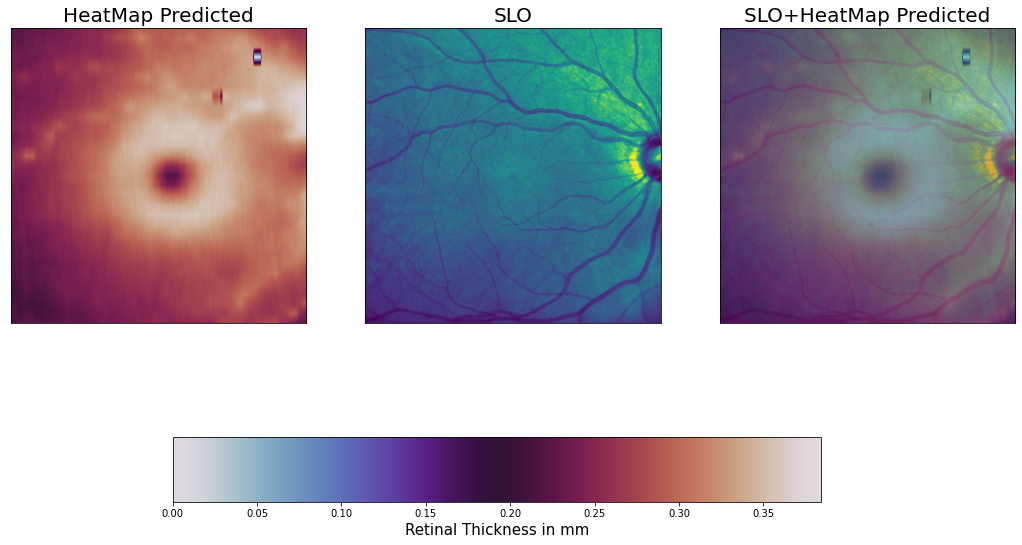

In [ ]:
import imutils
HeatMap = imutils.rotate(cv2.resize(Interpol2D*value_items['ScaleZ'],(value_items['SizeX'],value_items['SizeX'])),90)

fig, ax = plt.subplots(1,3,figsize=(18,9))
HeatMap2D = ax[0].imshow(HeatMap,cmap='twilight')
ax[0].set_title('HeatMap Predicted', fontsize='20')
ax[0].set_yticks([])
ax[0].set_xticks([])

ax[1].imshow(plt.imread('/content/drive/MyDrive/TFG/VOL IMAGES/' + Insert + '/SLO.jpg'))
ax[1].set_title('SLO', fontsize='20')
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].imshow(plt.imread('/content/drive/MyDrive/TFG/VOL IMAGES/' + Insert + '/SLO.jpg'))
ax[2].imshow(HeatMap, cmap='twilight', alpha=0.5)
ax[2].set_title('SLO+HeatMap Predicted', fontsize='20')
ax[2].set_yticks([])
ax[2].set_xticks([])

cax = plt.axes([0.25, -0.001, 0.5, 0.1])
for tick in cax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    
ColorBar = plt.colorbar(HeatMap2D, shrink=10, aspect=10, cax=cax, orientation='horizontal')
ColorBar.set_label(label='Retinal Thickness in mm',size=15)

plt.savefig('HeatMap2d.png')

plt.show()

